In [1]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install scapy

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install secure-smtplib

Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install pyshark

Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install nest_asyncio

Note: you may need to restart the kernel to use updated packages.


In [15]:
pip install --upgrade pyshark scapy

Note: you may need to restart the kernel to use updated packages.



🔍 Analyzing C:\Users\mages\OneDrive\Documents\dataset2.pcap...

📊 COMPREHENSIVE ANOMALY STATISTICS:
• Total Packets       : 11629
• TCP Packets         : 11345
• Duplicate ACKs      : 392
• Retransmissions     : 0
• Connection Resets   : 1258
• SYN Floods/Scans    : 2
• Large Packets       : 163
• Malformed Packets   : 0
• Protocol Violations : 17
• High Frequency Flows: 0

🚨 DETAILED ANOMALY CLASSIFICATION:

▸ Connection Reset (RST) (1258 instances):
Abnormal Packet at Line 8:
  Type: Connection Reset (RST)
  Protocol: TCP
  Source: 10.0.2.2:443
  Destination: 10.0.2.15:43624
  Reason: Abrupt connection termination.
Abnormal Packet at Line 10:
  Type: Connection Reset (RST)
  Protocol: TCP
  Source: 10.0.2.15:58304
  Destination: 10.0.2.2:80
  Reason: Abrupt connection termination.
Abnormal Packet at Line 25:
  Type: Connection Reset (RST)
  Protocol: TCP
  Source: 10.0.2.2:256
  Destination: 10.0.2.15:47746
  Reason: Abrupt connection termination.

▸ Duplicate ACK (392 instances):
A

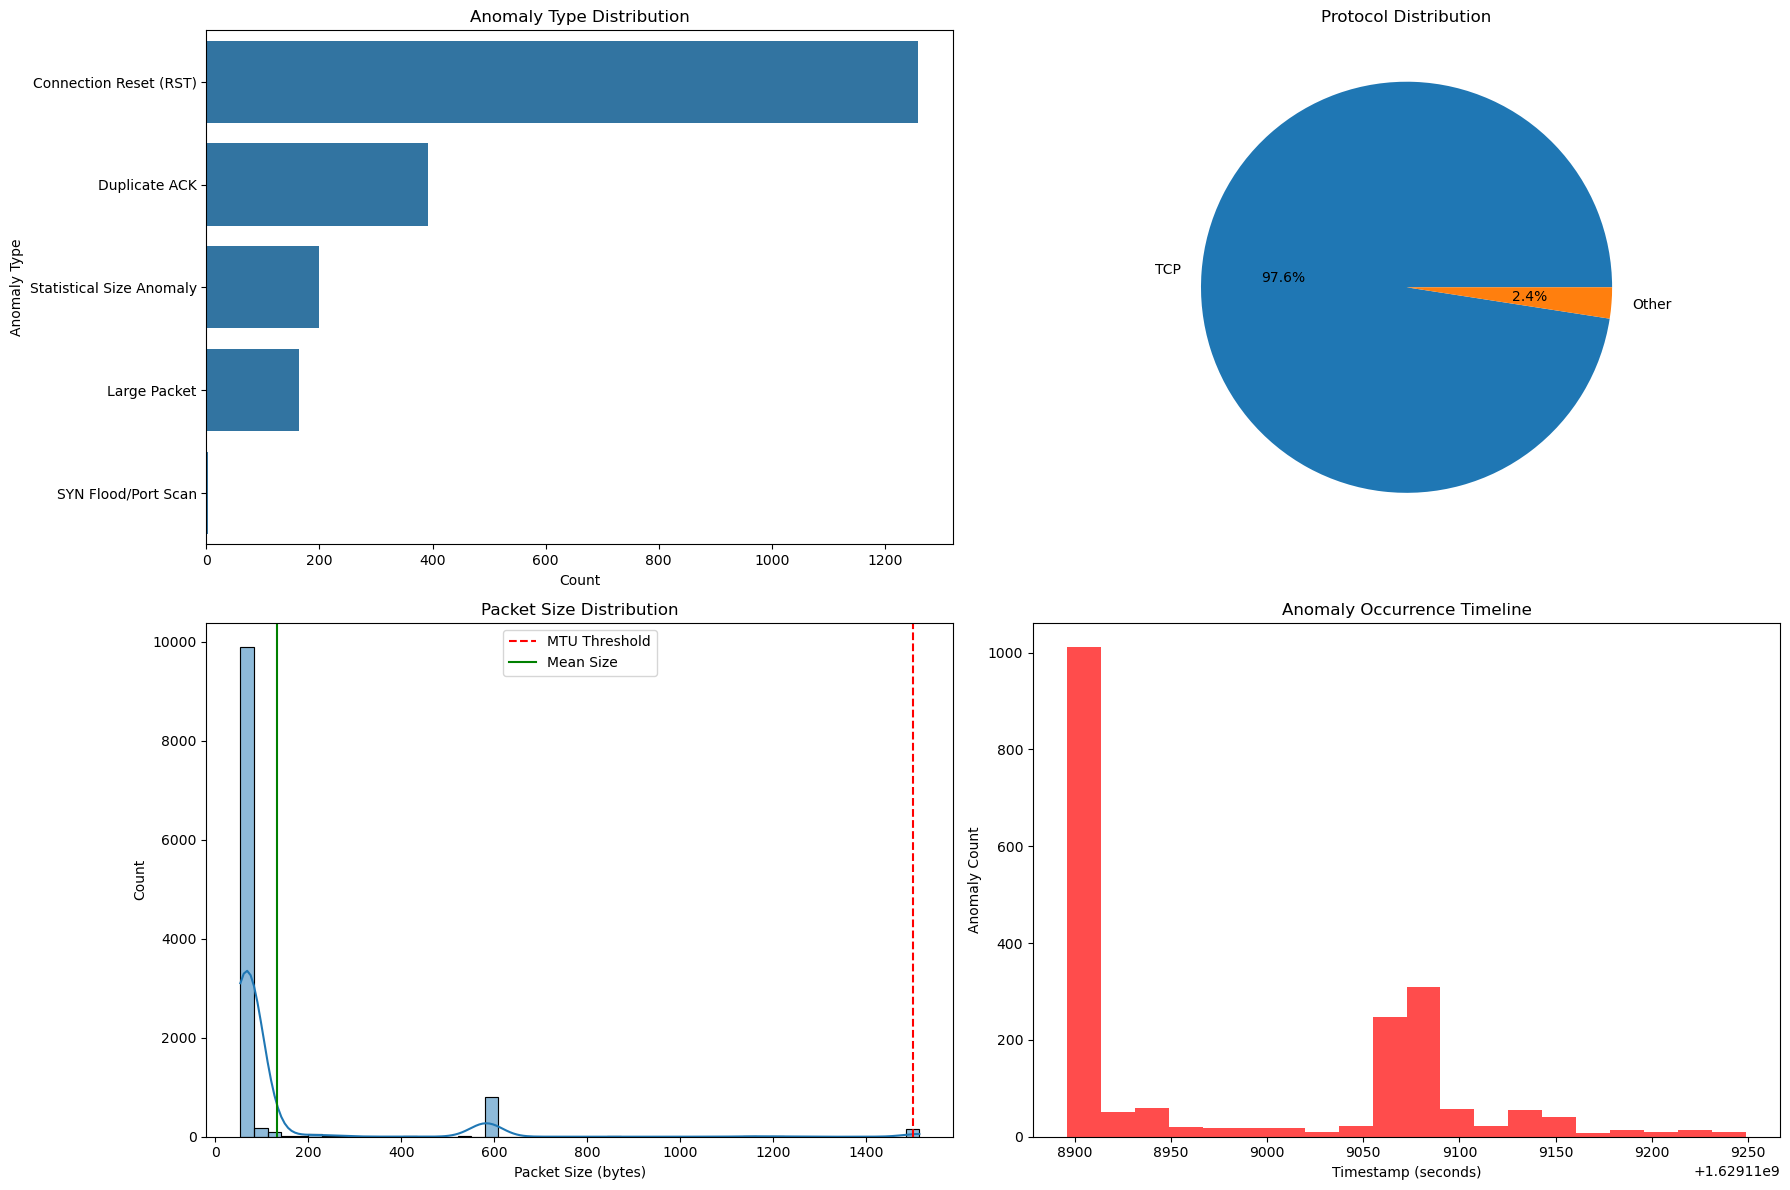

In [5]:
"""
PCAP Network Traffic Analyzer with Anomaly Detection
This script analyzes network traffic from PCAP files, detects various anomalies,
and generates comprehensive reports and visualizations.
"""

# ----------------------------
# IMPORT SECTION
# ----------------------------
import pandas as pd                     # For data manipulation and analysis
from scapy.all import *                 # For packet parsing and analysis
import matplotlib.pyplot as plt         # For data visualization
import seaborn as sns                   # For enhanced visualizations
from collections import defaultdict     # For dictionary with default values
import textwrap                         # For text formatting
import numpy as np                      # For numerical operations

# ----------------------------
# MAIN ANALYSIS FUNCTION
# ----------------------------
def analyze_pcap(pcap_file):
    """
    Main function to analyze PCAP file and detect network anomalies.
    
    Args:
        pcap_file (str): Path to the PCAP file to analyze
    """
    print(f"\n🔍 Analyzing {pcap_file}...")
    
    # ----------------------------
    # INITIALIZATION SECTION
    # ----------------------------
    # Read PCAP file and initialize data structures
    packets = rdpcap(pcap_file)         # Read all packets from PCAP
    anomalies = []                      # Store detected anomalies
    expert_info = []                    # Store protocol-specific findings

    # Initialize statistics dictionary
    stats = {
        'total_packets': len(packets),  # Total packets in file
        'tcp_packets': 0,               # Count of TCP packets
        'duplicate_acks': 0,            # Duplicate ACKs detected
        'retransmissions': 0,            # Packet retransmissions
        'resets': 0,                     # TCP connection resets
        'syn_floods': defaultdict(int),  # SYN flood attempts
        'large_packets': 0,              # Packets exceeding MTU
        'malformed': 0,                  # Malformed packets
        'protocol_violations': 0,        # Protocol violations
        'unusual_frequency': 0           # High frequency flows
    }

    # Initialize tracking data structures
    seq_tracker = defaultdict(list)     # Track sequence numbers
    ack_tracker = defaultdict(list)     # Track ACK numbers
    flow_tracker = defaultdict(list)     # Track network flows
    packet_sizes = []                   # Store packet sizes for analysis
    timestamps = []                     # Store packet timestamps

    # Time window analysis variables
    time_window = 1.0                   # 1-second analysis window
    current_window_start = packets[0].time if packets else 0  # First packet time
    window_counts = defaultdict(int)     # Count packets per flow per window

    # ----------------------------
    # PACKET PROCESSING LOOP
    # ----------------------------
    for i, pkt in enumerate(packets):
        pkt_num = i + 1                 # Packet number (1-based index)
        timestamps.append(pkt.time)      # Record timestamp

        # Skip non-IP/TCP packets
        if not (pkt.haslayer(IP) and pkt.haslayer(TCP)):
            continue

        # Extract packet layers and basic info
        ip = pkt[IP]
        tcp = pkt[TCP]
        stats['tcp_packets'] += 1
        length = len(pkt)
        packet_sizes.append(length)
        flow_key = (ip.src, ip.dst, tcp.sport, tcp.dport)  # Unique flow identifier

        # ----------------------------
        # TIME WINDOW ANALYSIS
        # ----------------------------
        if pkt.time - current_window_start > time_window:
            current_window_start = pkt.time
            window_counts.clear()
        window_counts[flow_key] += 1

        # ----------------------------
        # DUPLICATE ACK DETECTION
        # ----------------------------
        ack_key = (ip.src, ip.dst, tcp.ack)
        ack_tracker[ack_key].append(pkt_num)
        if 'A' in tcp.flags and len(ack_tracker[ack_key]) > 2:
            stats['duplicate_acks'] += 1
            anomalies.append({
                'packet': pkt_num,
                'type': 'Duplicate ACK',
                'protocol': 'TCP',
                'src': f"{ip.src}:{tcp.sport}",
                'dst': f"{ip.dst}:{tcp.dport}",
                'ack': tcp.ack,
                'count': len(ack_tracker[ack_key]),
                'reason': f"Multiple ACKs ({len(ack_tracker[ack_key])}) for same sequence number."
            })

        # ----------------------------
        # RETRANSMISSION DETECTION
        # ----------------------------
        seq_key = (ip.src, tcp.sport, tcp.seq)
        if 'PA' in tcp.flags and seq_key in seq_tracker:
            stats['retransmissions'] += 1
            anomalies.append({
                'packet': pkt_num,
                'type': 'Retransmission',
                'protocol': 'TCP',
                'src': f"{ip.src}:{tcp.sport}",
                'dst': f"{ip.dst}:{tcp.dport}",
                'seq': tcp.seq,
                'reason': f"Possible retransmission of sequence {tcp.seq}"
            })
        seq_tracker[seq_key] = pkt_num

        # ----------------------------
        # CONNECTION RESET DETECTION
        # ----------------------------
        if 'R' in tcp.flags:
            stats['resets'] += 1
            anomalies.append({
                'packet': pkt_num,
                'type': 'Connection Reset (RST)',
                'protocol': 'TCP',
                'src': f"{ip.src}:{tcp.sport}",
                'dst': f"{ip.dst}:{tcp.dport}",
                'reason': "Abrupt connection termination."
            })

        # ----------------------------
        # SYN FLOOD/PORT SCAN DETECTION
        # ----------------------------
        if tcp.flags == 'S':
            stats['syn_floods'][ip.src] += 1
            if stats['syn_floods'][ip.src] == 5:
                anomalies.append({
                    'packet': pkt_num,
                    'type': 'SYN Flood/Port Scan',
                    'protocol': 'TCP',
                    'src': ip.src,
                    'dst': f"{ip.dst}:{tcp.dport}",
                    'count': stats['syn_floods'][ip.src],
                    'reason': f"Excessive SYNs ({stats['syn_floods'][ip.src]}) from single source."
                })

        # ----------------------------
        # LARGE PACKET DETECTION
        # ----------------------------
        if length > 1500:
            stats['large_packets'] += 1
            anomalies.append({
                'packet': pkt_num,
                'type': 'Large Packet',
                'protocol': 'TCP',
                'length': length,
                'src': f"{ip.src}:{tcp.sport}",
                'dst': f"{ip.dst}:{tcp.dport}",
                'reason': f"Oversized packet ({length} > 1500 bytes)."
            })

        # ----------------------------
        # MALFORMED PACKET DETECTION
        # ----------------------------
        if len(pkt) < 20 or not pkt.haslayer(TCP) or not pkt.haslayer(IP):
            stats['malformed'] += 1
            anomalies.append({
                'packet': pkt_num,
                'type': 'Malformed Packet',
                'protocol': 'RAW',
                'length': len(pkt),
                'reason': "Invalid packet structure or size."
            })

        # ----------------------------
        # HTTP PROTOCOL VIOLATION DETECTION
        # ----------------------------
        if TCP in pkt and pkt[TCP].dport == 80 and Raw in pkt:
            if not (pkt[Raw].load.startswith(b'GET') or 
                    pkt[Raw].load.startswith(b'POST') or
                    pkt[Raw].load.startswith(b'HTTP')):
                stats['protocol_violations'] += 1
                expert_info.append({
                    'packet': pkt_num,
                    'type': 'Protocol Violation',
                    'protocol': 'TCP/HTTP',
                    'src': f"{ip.src}:{tcp.sport}",
                    'detail': "Non-HTTP traffic on port 80",
                    'payload': pkt[Raw].load[:50].hex()
                })

        # ----------------------------
        # HIGH FREQUENCY TRAFFIC DETECTION
        # ----------------------------
        if window_counts[flow_key] > 100:
            stats['unusual_frequency'] += 1
            anomalies.append({
                'packet': pkt_num,
                'type': 'High Frequency Traffic',
                'protocol': 'TCP',
                'src': f"{ip.src}:{tcp.sport}",
                'dst': f"{ip.dst}:{tcp.dport}",
                'count': window_counts[flow_key],
                'reason': f"High packet rate ({window_counts[flow_key]}/sec) detected."
            })

    # ----------------------------
    # STATISTICAL SIZE ANALYSIS
    # ----------------------------
    if packet_sizes:
        avg_size = np.mean(packet_sizes)
        std_size = np.std(packet_sizes)
        for i, size in enumerate(packet_sizes):
            if abs(size - avg_size) > 3 * std_size:
                pkt_num = i + 1
                if pkt_num <= len(packets) and packets[pkt_num-1].haslayer(IP) and packets[pkt_num-1].haslayer(TCP):
                    ip = packets[pkt_num-1][IP]
                    tcp = packets[pkt_num-1][TCP]
                    anomalies.append({
                        'packet': pkt_num,
                        'type': 'Statistical Size Anomaly',
                        'protocol': 'TCP',
                        'length': size,
                        'src': f"{ip.src}:{tcp.sport}",
                        'dst': f"{ip.dst}:{tcp.dport}",
                        'reason': f"Packet size {size} bytes (avg: {avg_size:.1f}±{std_size:.1f})"
                    })

    # ----------------------------
    # HELPER FUNCTION FOR TEXT WRAPPING
    # ----------------------------
    def print_wrapped(text, width=70):
        """Print text with wrapping to specified width."""
        print(textwrap.fill(text, width=width))

    # ----------------------------
    # REPORT GENERATION SECTION
    # ----------------------------
    print("\n📊 COMPREHENSIVE ANOMALY STATISTICS:")
    stat_items = [
        ('Total Packets', stats['total_packets']),
        ('TCP Packets', stats['tcp_packets']),
        ('Duplicate ACKs', stats['duplicate_acks']),
        ('Retransmissions', stats['retransmissions']),
        ('Connection Resets', stats['resets']),
        ('SYN Floods/Scans', len([a for a in anomalies if a['type'] == 'SYN Flood/Port Scan'])),
        ('Large Packets', stats['large_packets']),
        ('Malformed Packets', stats['malformed']),
        ('Protocol Violations', stats['protocol_violations']),
        ('High Frequency Flows', stats['unusual_frequency'])
    ]
    
    for name, value in stat_items:
        print(f"• {name:<20}: {value}")

    # ----------------------------
    # ANOMALY DETAILS REPORT
    # ----------------------------
    print("\n🚨 DETAILED ANOMALY CLASSIFICATION:")
    anomaly_types = set(a['type'] for a in anomalies)
    for anomaly_type in sorted(anomaly_types):
        count = len([a for a in anomalies if a['type'] == anomaly_type])
        examples = [a for a in anomalies if a['type'] == anomaly_type][:3]
        print(f"\n▸ {anomaly_type} ({count} instances):")
        for ex in examples:
            print(f"Abnormal Packet at Line {ex['packet']}:")
            print(f"  Type: {ex['type']}")
            print(f"  Protocol: {ex['protocol']}")
            if 'src' in ex:
                print(f"  Source: {ex['src']}")
            if 'dst' in ex:
                print(f"  Destination: {ex['dst']}")
            if 'length' in ex:
                print(f"  Length: {ex['length']} bytes")
            if 'count' in ex:
                print(f"  Count: {ex['count']}")
            print_wrapped(f"  Reason: {ex['reason']}", 60)

    # ----------------------------
    # EXPERT PROTOCOL ANALYSIS REPORT
    # ----------------------------
    if expert_info:
        print("\n⚠️ PROTOCOL VIOLATIONS (Expert Info):")
        for info in expert_info[:5]:
            print(f"\nPacket {info['packet']}:")
            print(f"  Type: {info['type']}")
            print(f"  Protocol: {info['protocol']}")
            print(f"  Source: {info['src']}")
            print(f"  Payload (hex): {info['payload']}")
            print_wrapped(f"  Detail: {info['detail']}", 60)

    # ----------------------------
    # VISUALIZATION SECTION
    # ----------------------------
    plt.figure(figsize=(18, 12))
    
    # Subplot 1: Anomaly Type Distribution
    plt.subplot(2, 2, 1)
    anomaly_df = pd.DataFrame(anomalies)
    if not anomaly_df.empty:
        sns.countplot(y='type', data=anomaly_df, order=anomaly_df['type'].value_counts().index)
    plt.title('Anomaly Type Distribution')
    plt.xlabel('Count')
    plt.ylabel('Anomaly Type')

    # Subplot 2: Protocol Distribution
    plt.subplot(2, 2, 2)
    protocol_counts = {
        'TCP': stats['tcp_packets'],
        'Other': stats['total_packets'] - stats['tcp_packets']
    }
    plt.pie(protocol_counts.values(), labels=protocol_counts.keys(), autopct='%1.1f%%')
    plt.title('Protocol Distribution')

    # Subplot 3: Packet Size Distribution
    plt.subplot(2, 2, 3)
    if packet_sizes:
        sns.histplot(packet_sizes, bins=50, kde=True)
        plt.axvline(1500, color='r', linestyle='--', label='MTU Threshold')
        plt.axvline(np.mean(packet_sizes), color='g', linestyle='-', label='Mean Size')
        plt.title('Packet Size Distribution')
        plt.xlabel('Packet Size (bytes)')
        plt.ylabel('Count')
        plt.legend()

    # Subplot 4: Anomaly Timeline
    plt.subplot(2, 2, 4)
    if timestamps and anomalies:
        anomaly_times = [packets[a['packet']-1].time for a in anomalies if a['packet']-1 < len(packets)]
        plt.hist(anomaly_times, bins=20, color='red', alpha=0.7)
        plt.title('Anomaly Occurrence Timeline')
        plt.xlabel('Timestamp (seconds)')
        plt.ylabel('Anomaly Count')

    plt.tight_layout()
    plt.show()

# ----------------------------
# MAIN EXECUTION BLOCK
# ----------------------------
if __name__ == "__main__":
    analyze_pcap(r'C:\Users\mages\OneDrive\Documents\dataset2.pcap')  # Update with your path